In [2]:
import mistralai
import os

MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")
client = mistralai.Mistral(api_key=MISTRAL_API_KEY)
client

In [3]:
import os

technical_reports_count = len([f for f in os.listdir("data/pdf/technical_reports") if os.path.isfile(os.path.join("data/pdf/technical_reports", f))])
market_reports_count = len([f for f in os.listdir("data/pdf/market_reports") if os.path.isfile(os.path.join("data/pdf/market_reports", f))])

print(f"Number of documents in data/pdf/technical_reports: {technical_reports_count}")
print(f"Number of documents in data/pdf/market_reports: {market_reports_count}")

Number of documents in data/pdf/technical_reports: 68
Number of documents in data/pdf/market_reports: 805


In [4]:
from PyPDF2 import PdfReader

def count_pages_in_folder(folder_path):
    total_pages = 0
    for file in os.listdir(folder_path):
        if file.endswith(".pdf"):
            try:
                with open(os.path.join(folder_path, file), "rb") as f:
                    reader = PdfReader(f)
                    total_pages += len(reader.pages)
            except Exception as e:
                pass
    return total_pages

technical_reports_pages = count_pages_in_folder("data/pdf/technical_reports")
market_reports_pages = count_pages_in_folder("data/pdf/market_reports")

print(f"Cumulative number of pages in technical reports: {technical_reports_pages}")
print(f"Cumulative number of pages in market reports: {market_reports_pages}")

Cumulative number of pages in technical reports: 328
Cumulative number of pages in market reports: 12154


OCR costs 1000 pages per dollar => approximately 12$ to process all pdfs

# Converting pdf into md with mistral OCR API

In [ ]:
from tqdm import tqdm
from mistralai import DocumentURLChunk
from utils import get_combined_markdown

# Create directory structure if it doesn't exist
os.makedirs("data/md/technical_reports", exist_ok=True)
os.makedirs("data/md/market_reports", exist_ok=True)

# Define folders to process
folders = [
    {"src": "data/pdf/technical_reports", "dest": "data/md/technical_reports", "prefix": "technical_report-"},
    {"src": "data/pdf/market_reports", "dest": "data/md/market_reports", "prefix": "market_report-"}
]

# Process all folders in a single loop
for folder in folders:
    errors = []

    for file in tqdm(os.listdir(folder["src"]), desc=f"Processing {folder['src']}"):
        document_path = f"{folder['dest']}/{file}".replace(".pdf", ".md")

        if file.endswith(".pdf") and not os.path.exists(document_path):
            try:
                # Upload file for OCR processing
                ocr_data = client.files.upload(
                    file={
                        "file_name": f"{folder['prefix']}{file}",
                        "content": open(f"{folder['src']}/{file}", "rb")
                    },
                    purpose="ocr"
                )
                
                # Get signed URL
                signed_url = client.files.get_signed_url(file_id=ocr_data.id, expiry=1)
                
                # Process document with OCR
                ocr_result = client.ocr.process(
                    document=DocumentURLChunk(document_url=signed_url.url),
                    model="mistral-ocr-latest",
                    include_image_base64=True
                )
                
                # Get combined markdown
                markdown_content = get_combined_markdown(ocr_result)
                
                # Write to output file
                with open(document_path, "w", encoding="utf-8") as f:
                    f.write(markdown_content)
                    
            except Exception as e:
                errors.append(f"{folder['src']}/{file}: {str(e)}")
                continue

    print(f"Errors: {errors}")
    print(f"Number of errors: {len(errors)}")


Processing data/pdf/technical_reports: 100%|██████████| 68/68 [00:00<00:00, 145368.33it/s]


Errors: []
Number of errors: 0


Processing data/pdf/market_reports: 100%|██████████| 805/805 [00:07<00:00, 100.63it/s]

Errors: ['data/pdf/market_reports/2024-01-12_Déclaration_d\'intention_préalable_annexe_1.pdf: API error occurred: Status 422\n{"detail": "Invalid file format.", "message": "Received file with mimetype application/vnd.openxmlformats-officedocument.spreadsheetml.sheet, only application/pdf, image/.*, application/vnd.openxmlformats-officedocument.wordprocessingml.document, application/vnd.openxmlformats-officedocument.presentationml.presentation, application/epub+zip, application/docbook+xml, application/rtf, application/vnd.oasis.opendocument.text, application/x-biblatex, application/x-bibtex, application/x-endnote+xml, application/x-fictionbook+xml, application/x-ipynb+json, application/x-jats+xml, application/x-latex, application/x-opml+xml, text/troff, text/x-dokuwiki are currently supported"}', 'data/pdf/market_reports/2024-05-13_Divers_documents_PO_autres_secteurs_Divers_documents_PO_autres_secteurs,_notamment_les.pdf: API error occurred: Status 422\n{"detail": "Invalid file format.

# Delete unavailable documents and old market reports (<= 2023)

In [39]:
import glob

delete_message = "Ce document est en cours d'élaboration. Il sera mis en ligne prochainement."

# Search all markdown files in both technical and market reports
md_files = glob.glob("data/md/technical_reports/*.md") + glob.glob("data/md/market_reports/*.md")

for file_path in md_files:
    with open(file_path, "r", encoding="utf-8") as f:
        content = f.read().strip()
    if content == delete_message:
        os.remove(file_path)
        print(f"Deleted: {file_path}")

Deleted: data/md/technical_reports/2024_fiche-technique_BCAE1_maintien-prairies-permanentes.md
Deleted: data/md/technical_reports/2024_fiche-technique_BCAE8_biodiversite_OM.md
Deleted: data/md/technical_reports/2024_fiche-technique_BCAE2_zones_humides.md
Deleted: data/md/technical_reports/2024_fiche-technique_BCAE3_interdiction_brulage_OM.md
Deleted: data/md/technical_reports/2024_fiche-technique_BCAE6_couverture_sol_OM.md
Deleted: data/md/technical_reports/2024_fiche-technique_BCAE4_bandes_tampons_OM.md
Deleted: data/md/technical_reports/2024_fiche-technique_BCAE2_zones_humides_OM.md
Deleted: data/md/technical_reports/2024_fiche-technique_BCAE9_prairies_sensibles.md
Deleted: data/md/technical_reports/PAC_CSP-Guide.md
Deleted: data/md/technical_reports/2024_fiche-technique_BCAE5_erosion_OM.md


In [113]:
import glob

# Delete all markdown files in market_reports starting with 2021, 2022 or 2023
for file_path in glob.glob("data/md/market_reports/2021*.md") + glob.glob("data/md/market_reports/2022*.md") + glob.glob("data/md/market_reports/2023*.md"):
    os.remove(file_path)
    print(f"Deleted: {file_path}")

Deleted: data/md/market_reports/2023-02-22_06_-_CUMA_Auvergne_Rhône_Alpes_PPT_CUMA_Auvergnes_Rhône_Alpes__machinisme_et_enje.md
Deleted: data/md/market_reports/2023-04-26_Info_riz_n°_333_du_21_avril_2023_Info_riz_relative_aux_échanges_et_cotations_de_riz.md
Deleted: data/md/market_reports/2023-03-15_Bilans_prévisionnels_du_Blé_tendre,_des_Orges,_du_Maïs_grain_et_du_Blé_dur_pour_2022_23_au_15_mars_2023_Bilans_prévisionnels_du_Blé_tendre,_des_Orges,_du_.md
Deleted: data/md/market_reports/2023-08-23_Résultats_partiels_au_21_août_2023_de_l'enquête_sur_la_qualité_de_la_récolte_française_de_blé_tendre_2023_FranceAgriMer,_en_partenariat_avec_ARVALIS_-_Insti.md
Deleted: data/md/market_reports/2023-02-22_02_-_Focus_Région_Grand-Est_PPT_Focus_Région_Grand-Est_-_Rencontres_Régionales.md
Deleted: data/md/market_reports/2023-02-22_03_-_Présentation_Lou_Pan_d'Ici_03_-_Présentation_Lou_Pan_d'Ici.md
Deleted: data/md/market_reports/2023-11-14_InfoCéréales_1204_-_14_novembre_2023___14th_November_2023_Fl

In [5]:
import glob

total_documents = len(glob.glob("data/md/technical_reports/*.md")) + len(glob.glob("data/md/market_reports/*.md"))
print(f"Total number of documents: {total_documents}")

Total number of documents: 286


# Generate Q&A from documents for RAG and LLM eval

<h3>Converting md files to pixtral format</h3>

[[{'type': 'text',
   'text': "En tant qu'agriculteur, quelles sont 5 questions que je pourrais poser à ce document ? Quelles sont les réponses ? La date doit être incluse dans la question si elle est pertinente."},
  {'type': 'text', 'text': '# Info sucRe'},
  {'type': 'image_url',
   'image_url': ''},
  {'type': 'text', 'text': 'Cours du sucre brut (NY n¹1)'},
  {'type': 'image_url',
   'image_url': ''},
  {'type': 'text', 'text': 'Taux de change (€/\\$)'},
  {'type': 'image_url',
   'image_url': ''},
  {'type': 'text', 'text': 'Cours du sucre brut (NY n¹1) en $€ / t$'},
  {'type': 'image_url',
   'image_url': ''},
  {'type': 'text',
   'text': 'Cours du sucre blanc (Londres $\\mathrm{n}^{\\circ} \\mathbf{5}$ ) $1^{\\text {er }}$ Terme'},
  {'type': 'image_url',
   'image_url': ''},
  {'type': 'text', 'text': 'Prime de blanc (\\$/t)'},
  {'type': 'image_url',
   'image_url': ''},
  {'type': 'text', 'text': 'Cours du sucre blanc à Londres en $€ / t$'},
  {'type': 'image_url',
   'imag
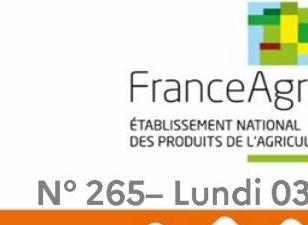
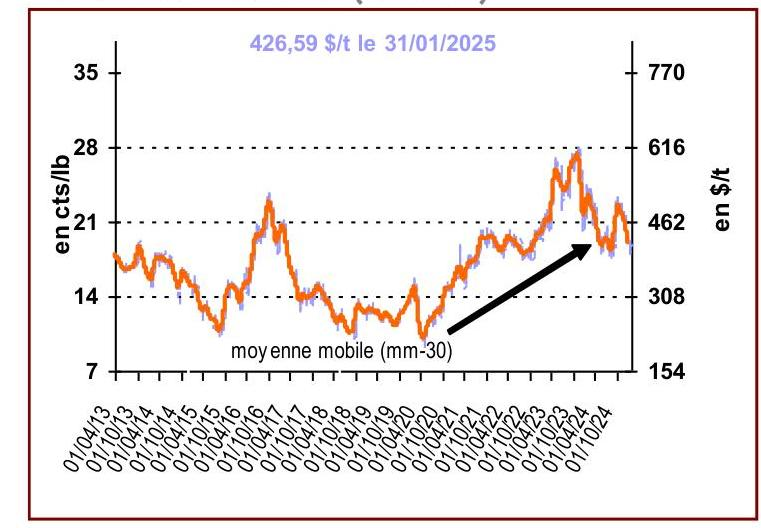
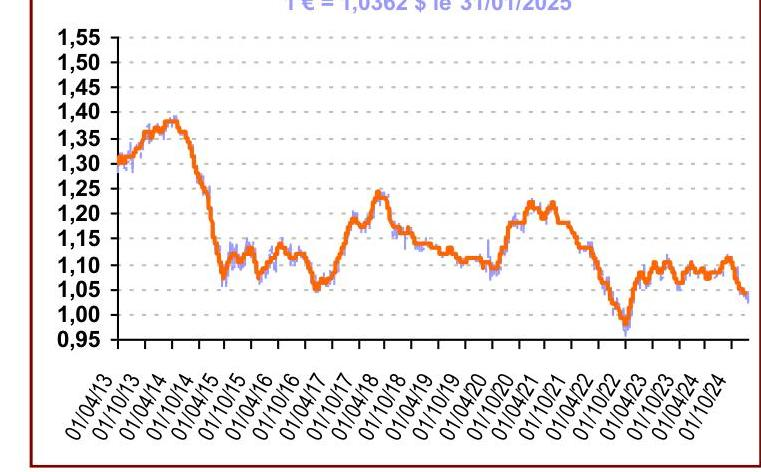
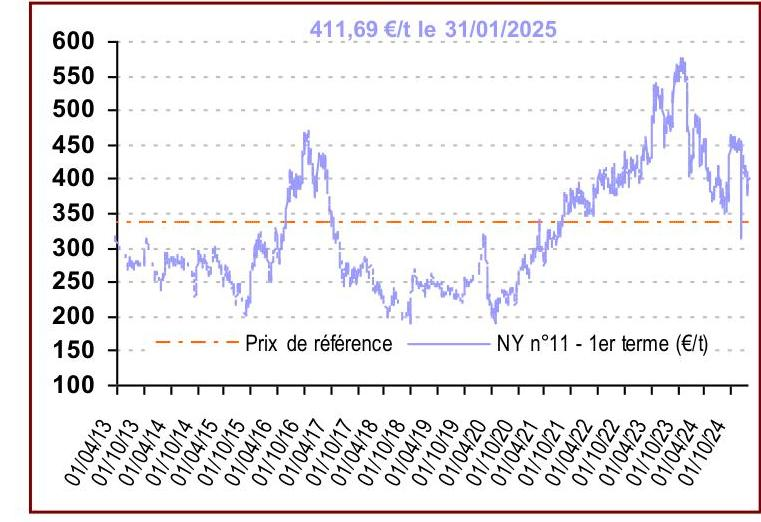
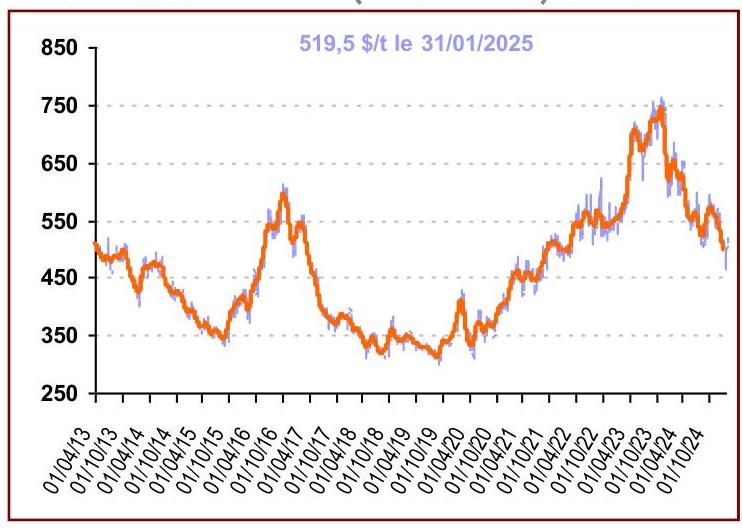
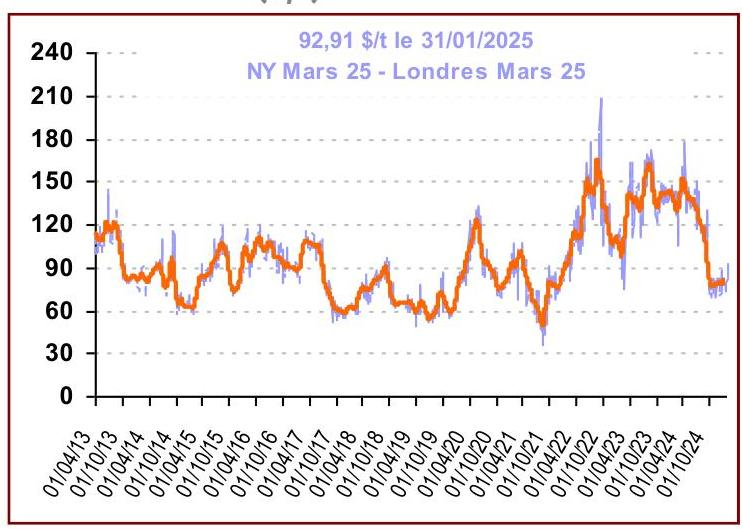
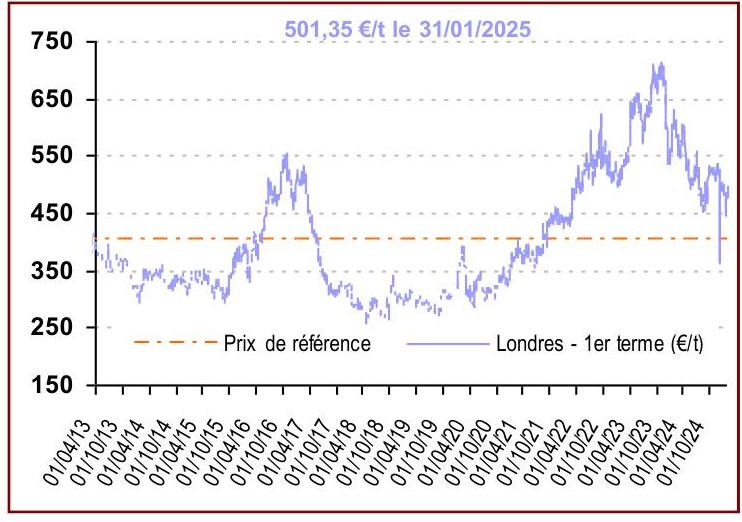
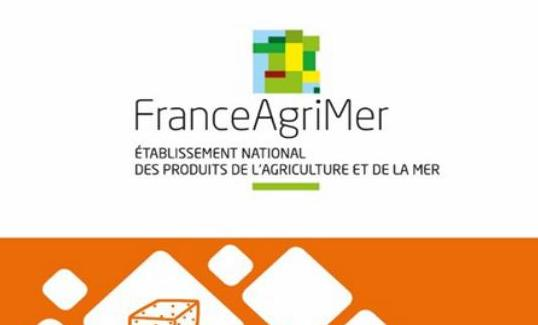
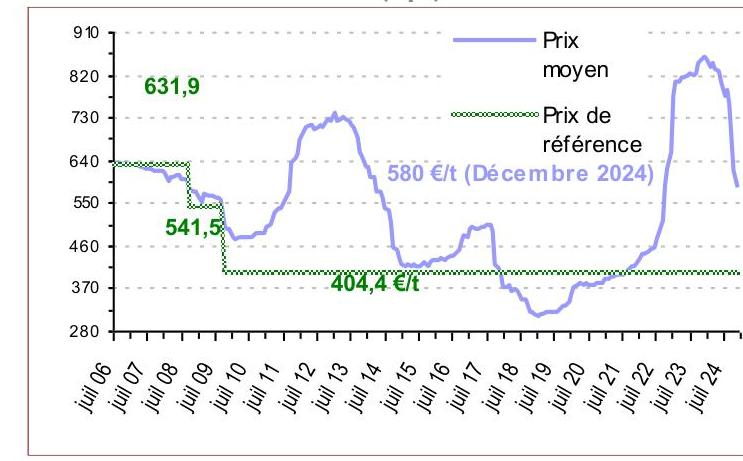
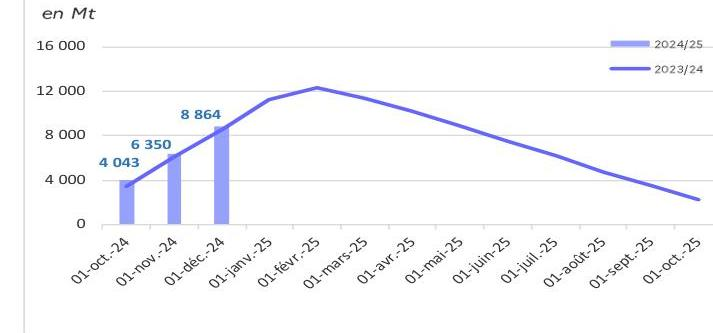
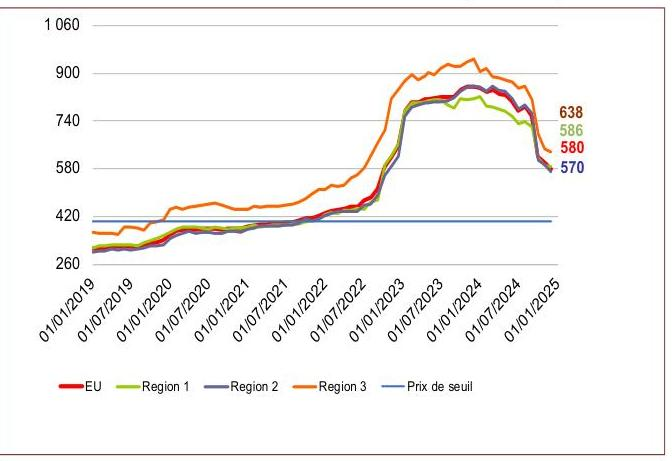

In [5]:
import re

document_path = "data/md/market_reports/2025-02-03_Info'Sucre_n°_265_Retrouvez_une_fois_par_mois_dans_l'info-sucre_les_.md"

def md_to_pixtral_format(document_path, user_query=None):
    """
    Converts a markdown document to Pixtral format. Generates several content arrays if the document contains more than 8 images.
    """
    with open(document_path, 'r', encoding="utf-8") as f:
        document_text = f.read()

        # Split the document into text and image references, preserving order
        parts = re.split(r'(!\[img-\d+\.jpeg\]\(.*?\))', document_text)

        # Initialize content array
        all_content_arrays = []
        content_array = [{"type": "text", "text": user_query}] if user_query else []
        image_count = 0
        
        for part in parts:
            if re.match(r'!\[img-\d+\.jpeg\]\((.*?)\)', part):
                # It's an image reference
                image_url = re.findall(r'!\[img-\d+\.jpeg\]\((.*?)\)', part)[0]
                
                # Check if we need to start a new content array due to image limit
                image_count += 1
                if image_count > 8:
                    all_content_arrays.append(content_array)
                    content_array = [{"type": "text", "text": user_query}] if user_query else []
                    image_count = 1
                
                content_array.append({"type": "image_url", "image_url": image_url})
            elif part.strip():
                # It's a text chunk
                content_array.append({"type": "text", "text": part.strip()})

        # Add the last content array if it has content
        if content_array:
            all_content_arrays.append(content_array)
            
        return all_content_arrays

content_array = md_to_pixtral_format(document_path, user_query="En tant qu'agriculteur, quelles sont 5 questions que je pourrais poser à ce document ? Quelles sont les réponses ? La date doit être incluse dans la question si elle est pertinente.")
content_array

<h3>Output format definition</h3>

In [6]:
from pydantic import BaseModel, Field
from typing import List

class QA(BaseModel):
    question: str = Field(
        ...,
        description="Une question qui peut être répondue à partir de ce document. La date doit être incluse dans la question si elle est pertinente.",
    )
    answer: str= Field(
        ...,
        description="La réponse à la question posée.",
    )

class QAList(BaseModel):
    q_and_a: List[QA] = Field(
        ...,
        description="Une liste de questions et réponses générées à partir d'un document référence.",
    )

<h2>Generate Q&A pairs</h2>

In [13]:
import pandas as pd
import nest_asyncio

import glob
import os
import asyncio

from tqdm.asyncio import tqdm_asyncio
nest_asyncio.apply()

model = "pixtral-large-latest"

async def process_document(document_path, folder_name):
    file_name = os.path.basename(document_path)
    
    content_arrays = md_to_pixtral_format(
        document_path,
        user_query="Je suis un agriculteur qui ne comprend pas très bien l'utilité de ce document, quelles sont 5 questions simples et utiles pour mon travail que je pourrais poser à ce document ? Quelles sont les réponses ? La date doit être incluse dans la question si elle est pertinente."
    )
    
    document_qa_data = []
    
    for content_array in content_arrays:
        # Create messages for the API call
        messages = [
            {
                "role": "user",
                "content": content_array
            }
        ]
        
        try:
            chat_response = client.chat.parse(
                model=model,
                messages=messages,
                response_format=QAList
            )
            
            for qa in chat_response.choices[0].message.parsed.q_and_a:
                document_qa_data.append({
                    "question": qa.question,
                    "answer": qa.answer,
                    "file_name": file_name,
                    "folder_name": folder_name,
                    "date": file_name.split("_")[0],
                })
        except Exception as e:
            print(f"Error processing {document_path}: {str(e)}")
    
    return document_qa_data

async def main():
    # Process all markdown files in both folders
    qa_data = []
    folders = ["data/md/technical_reports", "data/md/market_reports"]
    
    for folder in ["data/md/technical_reports"]:
        folder_name = os.path.basename(folder)
        document_paths = ["data/md/technical_reports/2024_fiche-technique_sante-vegetaux-2_paquet-hygiene.md"]
        
        # Process documents in parallel with a semaphore to limit concurrency
        semaphore = asyncio.Semaphore(1)  # Limit to 20 concurrent API calls

        async def process_with_semaphore(document_path):
            async with semaphore:
                return await process_document(document_path, folder_name)
        
        # Create tasks for all documents and process them concurrently
        tasks = [process_with_semaphore(doc_path) for doc_path in document_paths]
        results = await tqdm_asyncio.gather(*tasks, desc=f"Processing {folder}")
        
        # Flatten the results
        for result in results:
            if result:
                qa_data.extend(result)

    qa_df = pd.DataFrame(qa_data)
    qa_df.to_csv("qa_rag_eval.csv", index=False, encoding="utf-8")
    return qa_df

# Run the async main function
qa_df = asyncio.run(main())
qa_df

Processing data/md/technical_reports: 100%|██████████| 1/1 [00:25<00:00, 25.73s/it]


,question,answer,file_name,folder_name,date
0,Quel est l'objectif principal du règlement cad...,L'objectif principal est de garantir la sécuri...,2024_fiche-technique_sante-vegetaux-2_paquet-h...,technical_reports,2024
1,"En tant qu'agriculteur, suis-je concerné par l...","Oui, tous les exploitants agricoles qui produi...",2024_fiche-technique_sante-vegetaux-2_paquet-h...,technical_reports,2024
2,Quelles sont les principales exigences à respe...,Les principales exigences incluent la tenue d'...,2024_fiche-technique_sante-vegetaux-2_paquet-h...,technical_reports,2024
3,Que risque-t-on en cas d'absence totale de reg...,L'absence totale de registre phytopharmaceutiq...,2024_fiche-technique_sante-vegetaux-2_paquet-h...,technical_reports,2024
4,Quelles sont les conséquences si les produits ...,L'absence de local ou d'armoire dédiée au stoc...,2024_fiche-technique_sante-vegetaux-2_paquet-h...,technical_reports,2024


In [ ]:
concatenated_md = '\n'.join([page.markdown for page in ocr_result.pages])

def get_embeddings_by_chunks(data, chunk_size):
    chunks = [data[x : x + chunk_size] for x in range(0, len(data), chunk_size)]
    embeddings_response = [
        client.embeddings.create(model="mistral-embed", inputs=c) for c in chunks
    ]
    return [d.embedding for e in embeddings_response for d in e.data]

document_embeddings = get_embeddings_by_chunks(concatenated_md, 4000)
document_embeddings[:5]

[[-0.01129913330078125,
  0.0103759765625,
  0.0443115234375,
  -0.000988006591796875,
  0.01351165771484375,
  0.028778076171875,
  0.030548095703125,
  0.0056304931640625,
  -0.0023517608642578125,
  0.009490966796875,
  -0.043609619140625,
  0.0635986328125,
  -0.007724761962890625,
  0.00560760498046875,
  -0.05438232421875,
  0.01837158203125,
  0.003620147705078125,
  0.037261962890625,
  0.0254364013671875,
  0.017303466796875,
  -0.032135009765625,
  -0.0300140380859375,
  -0.03778076171875,
  0.01641845703125,
  -0.0083465576171875,
  -0.0007171630859375,
  0.007415771484375,
  -0.07061767578125,
  -0.0565185546875,
  0.0233154296875,
  0.0019092559814453125,
  -0.05792236328125,
  0.0051422119140625,
  -0.0021305084228515625,
  0.00860595703125,
  -0.00225067138671875,
  -0.0411376953125,
  -0.02252197265625,
  0.0212860107421875,
  0.0037975311279296875,
  -0.036376953125,
  -0.0204010009765625,
  0.00719451904296875,
  -0.01500701904296875,
  -0.0020751953125,
  -0.01209259

In [ ]:
import pandas as pd

qa_list = chat_response.choices[0].message.parsed.q_and_a

df = pd.DataFrame([
    {
        "document_name": "2022-02-11_01_-_Focus_des_Régions_Pays_de_Loire_et_Bretagne_01_-_Focus_des_Régions_Pays_de_Loire_et_Bretagne.md",
        "folder_name": "market_reports",
        "question": qa.question,
        "answer": qa.answer
    } for qa in qa_list
])

# Save to CSV
df.to_csv("qa_rag_eval.csv", index=False, encoding="utf-8")


In [ ]:
import pandas as pd

qa_list = chat_response.choices[0].message.parsed.q_and_a

df = pd.DataFrame([
    {
        "document_name": "2022-02-11_01_-_Focus_des_Régions_Pays_de_Loire_et_Bretagne_01_-_Focus_des_Régions_Pays_de_Loire_et_Bretagne.md",
        "folder_name": "market_reports",
        "question": qa.question,
        "answer": qa.answer
    } for qa in qa_list
])

# Save to CSV
df.to_csv("qa_rag_eval.csv", index=False, encoding="utf-8")


In [ ]:
import pandas as pd

qa_list = chat_response.choices[0].message.parsed.q_and_a

df = pd.DataFrame([
    {
        "document_name": "2022-02-11_01_-_Focus_des_Régions_Pays_de_Loire_et_Bretagne_01_-_Focus_des_Régions_Pays_de_Loire_et_Bretagne.md",
        "folder_name": "market_reports",
        "question": qa.question,
        "answer": qa.answer
    } for qa in qa_list
])

# Save to CSV
df.to_csv("qa_rag_eval.csv", index=False, encoding="utf-8")


In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance

qdrant_client = QdrantClient(":memory:")

qdrant_client.create_collection(
    collection_name="vegetables_recommandations",
    vectors_config=VectorParams(size=1024, distance=Distance.COSINE)
)

True

In [ ]:
from qdrant_client.models import PointStruct

points = [
    PointStruct(
        id=idx,
        vector=document_embeddings[idx],
        payload={"text": concatenated_md[idx*4000:(idx+1)*4000]}
    ) for idx in range(len(document_embeddings))
]

qdrant_client.upsert(
    collection_name="vegetables_recommandations",
    points=points
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [ ]:
query_embedding = client.embeddings.create(
    model="mistral-embed",
    inputs="How to grow tomatoes in a greenhouse?"
) 

chunks = qdrant_client.search(
    collection_name="vegetables_recommandations",
    query_vector=query_embedding.data[0].embedding,
    limit=5
)

result_text = "\n\n".join(chunk.payload["text"] for chunk in chunks)
print(result_text)


| 151.6 |
| 29-42 | 1.0 | 2.0 | 80.8 | 179.6 |
| 43-56 | 1.5 | 3.0 | 101.8 | 221.5 |
| 57-77 | 2.2 | 4.4 | 148.0 | 313.9 |
| 78-98 | 2.5 | 5.0 | 200.5 | 418.9 |

SUGGESTED FERTIGATION SCHEDULE FOR TOMATO* (high soil potassium)

| Days after planting | Daily nitrogen | Daily potash | Cumulative |  |
| :--: | :--: | :--: | :--: | :--: |
|  |  |  | Nitrogen | Potash |
|  | (Ib / A) |  |  |  |
| Preplant |  |  | 50.0 | 125.0 |
| $0-14$ | 0.5 | 0.5 | 57.0 | 132.0 |
| $15-28$ | 0.7 | 0.7 | 66.8 | 141.8 |
| 29-42 | 1.0 | 1.0 | 80.8 | 155.8 |
| 43-56 | 1.5 | 1.5 | 101.8 | 176.5 |
| 57-77 | 2.2 | 2.2 | 148.0 | 223.0 |
| 78-98 | 2.5 | 2.5 | 200.5 | 275.5 |

*Adjust based on tissue analysis.

Plasticulture. Yield, fruit size, and fruit quality of fresh market tomatoes can be increased and disease and weed issues reduced by the use of raised beds covered with plastic mulch in combination with drip irrigation. Early planted crops usually benefit from the soil warming provided by black plastic mulch

/tmp/ipykernel_78255/2905794585.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  chunks = qdrant_client.search(
